In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='W', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39567 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:43204 Dashboard: http://127.0.0.1:39567/status,Cluster Workers: 24 Cores: 168 Memory: 810.56 GB


In [ ]:
client.restart()
cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
client

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib as mpl
mpl.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/seas-forcing/'

In [4]:
U = .1
T = 5e5  # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 1500.+63
# f0 = 8e-5
beta = .5
N = 256    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = int(62.2*5)+1

nmemb = 100

In [5]:
for i in range(0,nmemb+1):
    if i < nmemb:
        if i == 0:
            ds = xr.open_zarr(op.join(ddir, 'run%03d/10percent/Fr-sqrt3_Ekb-2/vars000' % i)
                             ).isel(time=slice(-ntime,None))
            dsp1 = xr.open_zarr(op.join(ddir, 'run%03d/10percent/Fr-sqrt3_Ekb-2/psi_padded' % i)
                               ).isel(time=slice(-ntime,None))
        else:
            ds = xr.concat([ds,xr.open_zarr(op.join(ddir, 'run%03d/10percent/Fr-sqrt3_Ekb-2/vars000' % i)
                                           ).isel(time=slice(-ntime,None))
                           ], 'nmemb')
            dsp1 = xr.concat([dsp1,xr.open_zarr(op.join(ddir, 'run%03d/10percent/Fr-sqrt3_Ekb-2/psi_padded' % i)
                                               ).isel(time=slice(-ntime,None))
                             ], 'nmemb')
    else:
        ds = xr.concat([ds,xr.open_zarr(op.join(ddir, 'ctrl/10percent/Fr-sqrt3_Ekb-2/vars000')
                                       ).isel(time=slice(-ntime,None))
                       ], 'nmemb')
        dsp1 = xr.concat([dsp1,xr.open_zarr(op.join(ddir, 'ctrl/10percent/Fr-sqrt3_Ekb-2/psi_padded')
                                           ).isel(time=slice(-ntime,None))
                         ], 'nmemb')
    if i % 10 == 0:
        print(i)

ds.coords['nmemb'] = ('nmemb',range(nmemb+1))
dsp1.coords['nmemb'] = ('nmemb',range(nmemb+1))
ds = ds.chunk({'nmemb':6,'time':10,'Z':1,'Zp1':1})
dsp1 = dsp1.chunk({'nmemb':6,'time':10,'Z':1,'Zp1':1})
# dsw = dsw.chunk({'nmemb':6})
ds

<xarray.Dataset>
Dimensions:  (XC: 256, XG: 256, YC: 256, YG: 256, Z: 3, Zp1: 4, nmemb: 101, time: 312)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * XG       (XG) float64 0.0 0.3125 0.625 0.9375 ... 78.75 79.06 79.38 79.69
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YG       (YG) float64 0.0 0.3125 0.625 0.9375 ... 78.75 79.06 79.38 79.69
  * Z        (Z) float64 0.03 0.13 0.6
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drC      (Zp1) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    drF      (Z) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) float32 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
Data variables:
    p        (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(6, 10, 1, 128, 128), meta=np.ndarray>
    ptr0     (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(6, 10, 1, 128, 128), meta=np.ndarray>
    ptr1     (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(6, 10, 1, 128, 128), meta=np.ndarray>
    q        (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(6, 10, 1, 128, 128), meta=np.ndarray>

In [6]:
grid = Grid(ds, periodic=[],
            coords={'Z':{'center':'Z','outer':'Zp1'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )
gridz = Grid(ds.isel(Zp1=slice(1,-1)), periodic=[],
            coords={'Z':{'outer':'Z','center':'Zp1'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )

psib = ds.p.mean('nmemb')
psip = ds.p - psib
bb = -grid.diff(psib,'Z',boundary='extend') / ds.drC
bp = -grid.diff(psip,'Z',boundary='extend') / ds.drC

In [7]:
psi_padb = dsp1.psip1.mean('nmemb')
psi_padp = dsp1.psip1 - psi_padb
ub = -psi_padb.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
vb = psi_padb.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
up = -psi_padp.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
vp = psi_padp.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
ub

,Array,Chunk
Bytes,328.43 MB,792.00 kB
Shape,"(312, 2, 257, 256)","(10, 1, 99, 100)"
Count,1745534 Tasks,960 Chunks
Type,float64,numpy.ndarray


In [8]:
vortp1b = xr.DataArray(vb.diff('Xp1').data - ub.diff('Yp1').data,
                       dims=['time','Zp1','YC','XC'], 
                       coords={'time':ds.time.data,
                               'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                               'YC':ds.YC.data,'XC':ds.XC.data}
                      ) / dx
# (vortb*Rom).isel(time=-1,Zp1=0).plot(vmax=.2)
vortp1b

,Array,Chunk
Bytes,327.16 MB,768.32 kB
Shape,"(312, 2, 256, 256)","(10, 1, 98, 98)"
Count,1786430 Tasks,3136 Chunks
Type,float64,numpy.ndarray


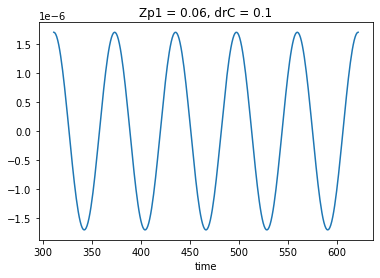

In [9]:
eps = Ekb * (2*Rom*ds.drF.isel(Z=-1))
dEk = Ekb * (ds.drF.isel(Z=-1).values)
Frm = xr.DataArray(np.array([0.00409959,0.01319355]), dims='Zp1', 
                   coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))}
                  )
aFrN = xr.DataArray(np.array([0.1,0.]), dims='Zp1', 
                    coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))}
                   )
fFr_r = 62.2
Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*ds.time)*aFrN)**-1 * Frm
N2 = Fr**-2
gp = N2 * ds.drC.isel(Zp1=slice(1,-1))
gpinv_t = (np.cos(2*np.pi*fFr_r**-1*ds.time) 
           * Frm**2 * ds.drC.isel(Zp1=slice(1,-1))**-1*aFrN*(2*np.pi*fFr_r**-1)
          )
gpinv_t.isel(Zp1=0).plot()

In [9]:
X = .5*xr.DataArray((up**2).mean('nmemb').isel(Yp1=slice(None,-1)).data 
                    + (up**2).mean('nmemb').isel(Yp1=slice(1,None)).data,
                    dims=['time','Zp1','YC','XC'], 
                    coords={'time':ds.time.data,'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                            'YC':ds.YC.data,'XC':ds.XC.data})
Y = .5*xr.DataArray((vp**2).mean('nmemb').isel(Xp1=slice(None,-1)).data 
                    + (vp**2).mean('nmemb').isel(Xp1=slice(1,None)).data,
                    dims=['time','Zp1','YC','XC'], 
                    coords={'time':ds.time.data,'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                            'YC':ds.YC.data,'XC':ds.XC.data})
N = (xr.DataArray(vp.isel(Xp1=slice(None,-1)).data 
                  + vp.isel(Xp1=slice(1,None)).data,
                  dims=['nmemb','time','Zp1','YC','XC'], 
                  coords={'nmemb':ds.nmemb.data,'time':ds.time.data,
                          'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                          'YC':ds.YC.data,'XC':ds.XC.data})
     * xr.DataArray(up.isel(Yp1=slice(None,-1)).data 
                    + up.isel(Yp1=slice(1,None)).data,
                    dims=['nmemb','time','Zp1','YC','XC'], 
                    coords={'nmemb':ds.nmemb.data,'time':ds.time.data,
                            'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                            'YC':ds.YC.data,'XC':ds.XC.data})
    ).mean('nmemb') * .25
P = .5*(bp**2).mean('nmemb') * Fr**2
R = (bp * .5*xr.DataArray(up.isel(Yp1=slice(None,-1)).data 
                          + up.isel(Yp1=slice(1,None)).data,
                          dims=['nmemb','time','Zp1','YC','XC'], 
                          coords={'nmemb':ds.nmemb.data,'time':ds.time.data,
                                  'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                                  'YC':ds.YC.data,'XC':ds.XC.data})
    ).mean('nmemb') / Rom*Fr**2
S = -(bp * .5*xr.DataArray(vp.isel(Xp1=slice(None,-1)).data 
                           + vp.isel(Xp1=slice(1,None)).data,
                           dims=['nmemb','time','Zp1','YC','XC'], 
                           coords={'nmemb':ds.nmemb.data,'time':ds.time.data,
                                   'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                                   'YC':ds.YC.data,'XC':ds.XC.data})
     ).mean('nmemb') / Rom*Fr**2
S

<xarray.DataArray (time: 312, Zp1: 2, YC: 256, XC: 256)>
dask.array<mul, shape=(312, 2, 256, 256), dtype=float64, chunksize=(10, 1, 99, 98), chunktype=numpy.ndarray>
Coordinates:
  * Zp1      (Zp1) float64 0.06 0.2
  * time     (time) float32 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
    drC      (Zp1) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [10]:
# dsave = X.to_dataset(name="X")
# dsave["Y"] = Y
# dsave["N"] = N
# dsave["P"] = P
# dsave["R"] = R
# dsave["S"] = S
# dsave = dsave.drop('drC')
# dsave = dsave.chunk({'time':20,'YC':128,'XC':128})
# dsave.to_zarr(op.join(ddir,"E-P000/"), mode='w')
dsep = xr.open_zarr(op.join(ddir,"E-P000/"))
X = dsep.X
Y = dsep.Y
N = dsep.N
P = dsep.P
R = dsep.R
S = dsep.S

In [11]:
E00 = X + P
E01 = N
E11 = Y + P
E20 = S
E21 = R
E00

<xarray.DataArray (time: 312, Zp1: 2, YC: 256, XC: 256)>
dask.array<add, shape=(312, 2, 256, 256), dtype=float64, chunksize=(20, 1, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * Zp1      (Zp1) float64 0.06 0.2
  * time     (time) float32 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0

In [22]:
vortb = xr.DataArray(((ds.drC.isel(Zp1=slice(2,-1)).data
                       * vortp1b.isel(Zp1=slice(None,-1)).data
                       + ds.drC.isel(Zp1=slice(1,-2)).data
                       * vortp1b.isel(Zp1=slice(1,None)).data
                      ) / (ds.drC.isel(Zp1=slice(2,-1)).data + ds.drC.isel(Zp1=slice(1,-2)).data
                          ))[:,0],
                   dims=['time','YC','XC'], 
                   coords={'time':ds.time.data,
                           'YC':ds.YC.data,'XC':ds.YC.data})
N2m = xr.DataArray(((ds.drC.isel(Zp1=slice(2,-1)).data 
                     * N2.isel(Zp1=slice(None,-1)).data
                     + ds.drC.isel(Zp1=slice(1,-2)).data 
                     * N2.isel(Zp1=slice(1,None)).data
                    ) / (ds.drC.isel(Zp1=slice(2,-1)).data + ds.drC.isel(Zp1=slice(1,-2)).data
                        ))[:,0],
                  dims=['time'], 
                  coords={'time':ds.time.data})
Pib = N2m*(beta*(ds.YC-ds.YC.mean()) + vortb) + 1/Rom * -grid.diff(bb,'Z',boundary='extend').isel(Z=1)/ds.drF.isel(Z=1)
Pib

<xarray.DataArray (time: 312, YC: 256, XC: 256)>
dask.array<add, shape=(312, 256, 256), dtype=float64, chunksize=(10, 98, 98), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float32 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
    Z        float64 0.13
    drF      float64 dask.array<chunksize=(), meta=np.ndarray>

In [30]:
qp1 = xr.DataArray((ds.drF.isel(Z=slice(1,None)).data[np.newaxis,np.newaxis,:,np.newaxis,np.newaxis]
                   * ds.q.isel(Z=slice(None,-1)).data
                   + ds.drF.isel(Z=slice(None,-1)).data[np.newaxis,np.newaxis,:,np.newaxis,np.newaxis]
                   * ds.q.isel(Z=slice(1,None)).data
                   ) / (ds.drF.isel(Z=slice(None,-1)).data 
                        + ds.drF.isel(Z=slice(1,None)).data)[np.newaxis,np.newaxis,:,np.newaxis,np.newaxis],
                   dims=['nmemb','time','Zp1','YC','XC'], 
                   coords={'nmemb':ds.nmemb.data,
                           'time':ds.time.data,'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                           'YC':ds.YC.data,'XC':ds.YC.data})
qp1

,Array,Chunk
Bytes,33.04 GB,7.86 MB
Shape,"(101, 312, 2, 256, 256)","(6, 10, 1, 128, 128)"
Count,777016 Tasks,4352 Chunks
Type,float64,numpy.ndarray


In [32]:
qp1b_1 = qp1.isel(Zp1=0,time=-15).mean('nmemb').compute()

In [13]:
Pib_1 = Pib.isel(time=-15).compute()
E00_1 = E00.isel(Zp1=0,time=-15).compute()
E01_1 = E01.isel(Zp1=0,time=-15).compute()
E11_1 = E11.isel(Zp1=0,time=-15).compute()
E20_1 = E20.isel(Zp1=0,time=-15).compute()
E21_1 = E21.isel(Zp1=0,time=-15).compute()

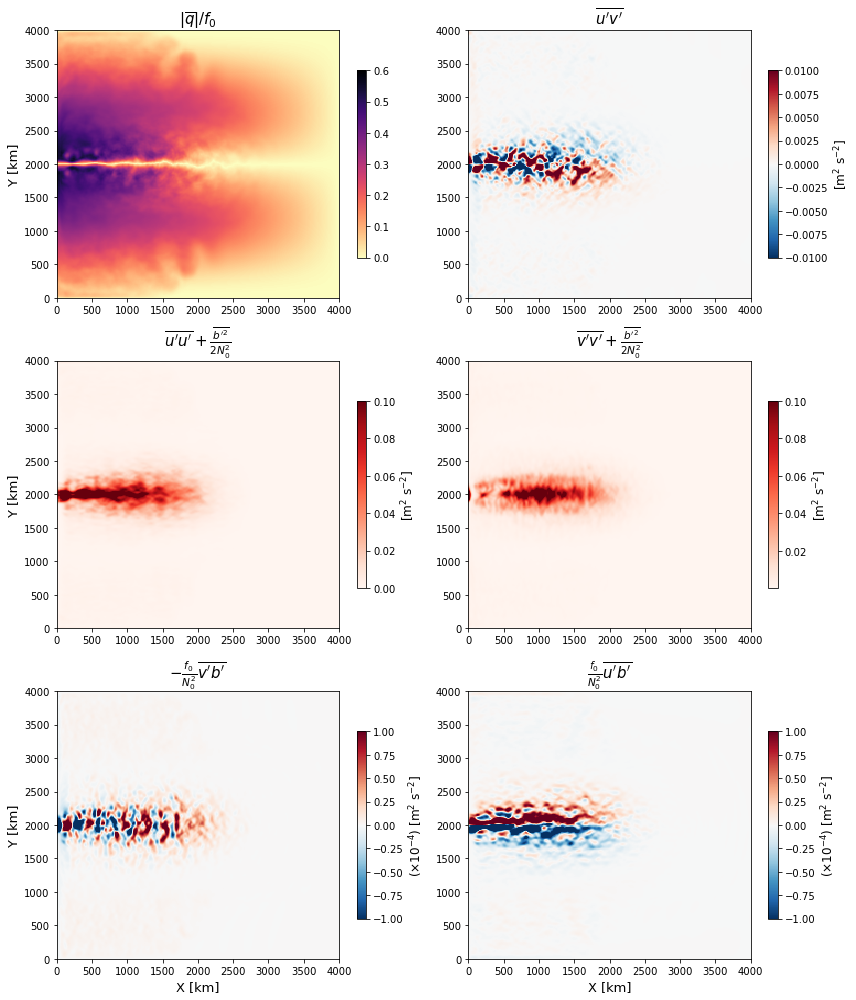

In [40]:
fig, axes = plt.subplots(figsize=(12,14), nrows=3, ncols=2)
fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, 
                           np.abs(qp1b_1)*Rom, 
                           vmin=0., vmax=.6,
#                            norm=clr.SymLogNorm(linthresh=1e-3, vmin=-.1, vmax=.1, base=10.), 
                           cmap='magma_r', rasterized=True)
im1 = axes[0,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3,
                           E01_1*U**2,
                           vmin=-1e-2, vmax=1e-2,
#                            norm=clr.SymLogNorm(linthresh=1e-4, vmin=-1e-2, vmax=1e-2, base=10.), 
                           cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3,
                           E00_1*U**2, 
                           vmin=0., vmax=1e-1,
#                            norm=clr.LogNorm(vmin=1e-4, vmax=1e-1), 
                           cmap='Reds', rasterized=True)
im3 = axes[1,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3,
                           E11_1*U**2, 
                           vmin=1e-4, vmax=1e-1,
#                            norm=clr.LogNorm(vmin=1e-4, vmax=1e-1),
                           cmap='Reds', rasterized=True)
im4 = axes[2,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3,
                           E20_1*U**2 * 1e4, 
                           vmin=-1, vmax=1,
#                            norm=clr.SymLogNorm(linthresh=1e-6, vmin=-1e-4, vmax=1e-4, base=10.),
                           cmap='RdBu_r', rasterized=True)
im5 = axes[2,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, 
                           E21_1*U**2*1e4, 
                           vmin=-1, vmax=1,
#                            norm=clr.SymLogNorm(linthresh=1e-6, vmin=-1e-4, vmax=1e-4, base=10.),
                           cmap='RdBu_r', rasterized=True)

axes[0,0].set_title(r"$|\overline{q}|/f_0$", fontsize=15)
axes[1,0].set_title(r"$\overline{u'u'} + \frac{\overline{b'^2}}{2 N_0^2}$", 
                    fontsize=15)
axes[0,1].set_title(r"$\overline{u'v'}$", fontsize=15)
axes[1,1].set_title(r"$\overline{v'v'} + \frac{\overline{b'^2}}{2 N_0^2}$", 
                    fontsize=15)
axes[2,0].set_title(r"$-\frac{f_0}{N_0^2}\overline{v'b'}$", 
                    fontsize=15)
axes[2,1].set_title(r"$\frac{f_0}{N_0^2}\overline{u'b'}$", 
                    fontsize=15)

axes[2,0].set_xlabel(r"X [km]", fontsize=13)
axes[2,1].set_xlabel(r"X [km]", fontsize=13)
axes[0,0].set_ylabel(r"Y [km]", fontsize=13)
axes[1,0].set_ylabel(r"Y [km]", fontsize=13)
axes[2,0].set_ylabel(r"Y [km]", fontsize=13)

cbar0 = fig.colorbar(im0, ax=axes[0,0], shrink=.7)
# cbar0.set_label(r"[s$^{-2}$]", fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0,1], shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1,0], shrink=.7)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.7)
cbar3.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
cbar4 = fig.colorbar(im4, ax=axes[2,0], shrink=.7)
cbar4.set_label(r"($\times 10^{-4}$) [m$^2$ s$^{-2}$]", fontsize=12)
cbar5 = fig.colorbar(im5, ax=axes[2,1], shrink=.7)
cbar5.set_label(r"($\times 10^{-4}$) [m$^2$ s$^{-2}$]", fontsize=12)

plt.savefig(op.join(ddir,'../Figs/E-P_flux_lastwinter.pdf'))

In [15]:
e00_x = gridz.diff(E00,'X',boundary='fill',fill_value=0.) / dx
e10_y = gridz.diff(N,'Y',boundary='fill',fill_value=0.) / dx

e01_x = gridz.diff(N,'X',boundary='fill',fill_value=0.) / dx
e11_y = gridz.diff(E11,'Y',boundary='fill',fill_value=0.) / dx

e20_z = -gridz.diff(E20,'Z',boundary='extend').isel(Z=1) / ds.drF.isel(Z=1)
e21_z = -gridz.diff(E21,'Z',boundary='extend').isel(Z=1) / ds.drF.isel(Z=1)
e20_z

<xarray.DataArray (time: 312, YC: 256, XC: 256)>
dask.array<truediv, shape=(312, 256, 256), dtype=float64, chunksize=(20, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float32 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
    Z        float64 0.13
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
    drF      float64 dask.array<chunksize=(), meta=np.ndarray>

In [16]:
# e00_xC = xr.ones_like(e20_z).load() * np.nan
e00_xC = xr.DataArray(((ds.drC.isel(Zp1=slice(2,-1)).data[np.newaxis,:,np.newaxis,np.newaxis] 
                     * e00_x.isel(Zp1=slice(None,-1)).data
                     + ds.drC.isel(Zp1=slice(1,-2)).data[np.newaxis,:,np.newaxis,np.newaxis] 
                     * e00_x.isel(Zp1=slice(1,None)).data
                    ) / (ds.drC.isel(Zp1=slice(2,-1)).data + ds.drC.isel(Zp1=slice(1,-2)).data
                        )[np.newaxis,:,np.newaxis,np.newaxis])[:,0],
                             dims=e20_z.dims, coords=e20_z.coords)
# e01_xC = xr.ones_like(e21_z).load() * np.nan
e01_xC = xr.DataArray(((ds.drC.isel(Zp1=slice(2,-1)).data[np.newaxis,:,np.newaxis,np.newaxis] 
                     * e01_x.isel(Zp1=slice(None,-1)).data
                     + ds.drC.isel(Zp1=slice(1,-2)).data[np.newaxis,:,np.newaxis,np.newaxis] 
                     * e01_x.isel(Zp1=slice(1,None)).data
                    ) / (ds.drC.isel(Zp1=slice(2,-1)).data + ds.drC.isel(Zp1=slice(1,-2)).data
                        )[np.newaxis,:,np.newaxis,np.newaxis])[:,0],
                             dims=e21_z.dims, coords=e21_z.coords)
# e10_xC = xr.ones_like(e20_z).load() * np.nan
e10_yC = xr.DataArray(((ds.drC.isel(Zp1=slice(2,-1)).data[np.newaxis,:,np.newaxis,np.newaxis] 
                     * e10_y.isel(Zp1=slice(None,-1)).data
                     + ds.drC.isel(Zp1=slice(1,-2)).data[np.newaxis,:,np.newaxis,np.newaxis] 
                     * e10_y.isel(Zp1=slice(1,None)).data
                    ) / (ds.drC.isel(Zp1=slice(2,-1)).data + ds.drC.isel(Zp1=slice(1,-2)).data
                        )[np.newaxis,:,np.newaxis,np.newaxis])[:,0],
                             dims=e20_z.dims, coords=e20_z.coords)
# e11_xC = xr.ones_like(e20_z).load() * np.nan
e11_yC = xr.DataArray(((ds.drC.isel(Zp1=slice(2,-1)).data[np.newaxis,:,np.newaxis,np.newaxis] 
                     * e11_y.isel(Zp1=slice(None,-1)).data
                     + ds.drC.isel(Zp1=slice(1,-2)).data[np.newaxis,:,np.newaxis,np.newaxis] 
                     * e11_y.isel(Zp1=slice(1,None)).data
                    ) / (ds.drC.isel(Zp1=slice(2,-1)).data + ds.drC.isel(Zp1=slice(1,-2)).data
                        )[np.newaxis,:,np.newaxis,np.newaxis])[:,0],
                             dims=e21_z.dims, coords=e21_z.coords)
Eu = (e00_xC + e10_yC)*U**2/Rd + e20_z*U**2/H
Ev = (e01_xC + e11_yC)*U**2/Rd + e21_z*U**2/H
Eu

<xarray.DataArray (time: 312, YC: 256, XC: 256)>
dask.array<add, shape=(312, 256, 256), dtype=float64, chunksize=(20, 127, 127), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float32 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
    Z        float64 0.13
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
    drF      float64 dask.array<chunksize=(), meta=np.ndarray>

In [17]:
e00_x1 = e00_xC.isel(time=-15).compute()
e10_y1 = e10_yC.isel(time=-15).compute()
e01_x1 = e01_xC.isel(time=-15).compute()
e11_y1 = e11_yC.isel(time=-15).compute()
e20_z1 = e20_z.isel(time=-15).compute()
e21_z1 = e21_z.isel(time=-15).compute()
Eu_1 = Eu.isel(time=-15).compute()
Ev_1 = Ev.isel(time=-15).compute()

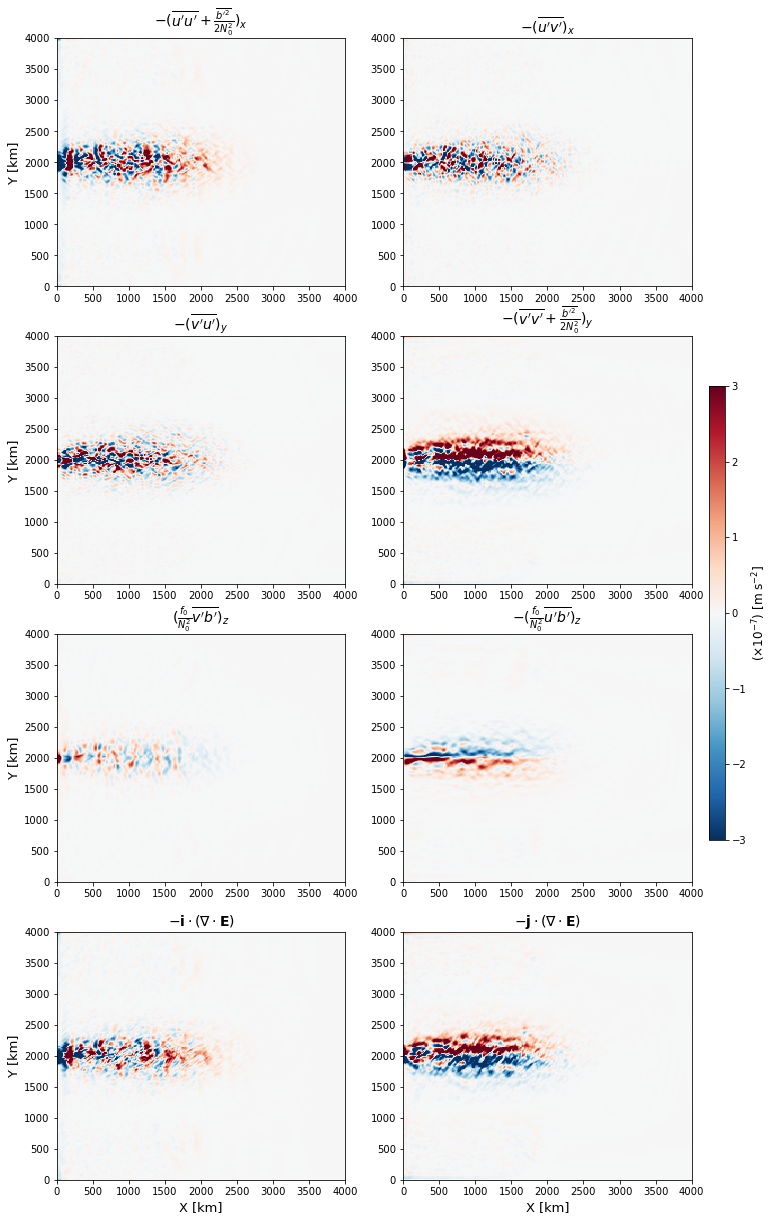

In [38]:
fig, axes = plt.subplots(figsize=(12,21), nrows=4, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3,
                          -e00_x1 * U**2/Rd*1e7, 
                          vmin=-3, vmax=3,
#                           norm=clr.SymLogNorm(linthresh=1e-9, vmin=-2e-7, vmax=2e-7, base=10.),
                          cmap='RdBu_r', rasterized=True)
axes[1,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3,
                     -e10_y1 * U**2/Rd*1e7, 
                          vmin=-3, vmax=3,
#                      norm=clr.SymLogNorm(linthresh=1e-9, vmin=-2e-7, vmax=2e-7, base=10.),
                     cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3,
                     -e01_x1 * U**2/Rd*1e7, 
                          vmin=-3, vmax=3,
#                      norm=clr.SymLogNorm(linthresh=1e-9, vmin=-2e-7, vmax=2e-7, base=10.),
                     cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, 
                     -e11_y1 * U**2/Rd*1e7, 
                          vmin=-3, vmax=3,
#                      norm=clr.SymLogNorm(linthresh=1e-9, vmin=-2e-7, vmax=2e-7, base=10.),
                     cmap='RdBu_r', rasterized=True)
axes[2,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, 
                     -e20_z1 * U**2/H*1e7, 
                          vmin=-3, vmax=3,
#                      norm=clr.SymLogNorm(linthresh=1e-9, vmin=-2e-7, vmax=2e-7, base=10.),
                     cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, 
                     -e21_z1 * U**2/H*1e7, 
                          vmin=-3, vmax=3,
#                      norm=clr.SymLogNorm(linthresh=1e-9, vmin=-2e-7, vmax=2e-7, base=10.),
                     cmap='RdBu_r', rasterized=True)
axes[3,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3,
                     -Eu_1*1e7, 
                          vmin=-3, vmax=3,
#                      norm=clr.SymLogNorm(linthresh=1e-9, vmin=-2e-7, vmax=2e-7, base=10.),
                     cmap='RdBu_r', rasterized=True)
axes[3,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, 
                     -Ev_1*1e7, 
                          vmin=-3, vmax=3,
#                      norm=clr.SymLogNorm(linthresh=1e-9, vmin=-2e-7, vmax=2e-7, base=10.),
                     cmap='RdBu_r', rasterized=True)


axes[0,0].set_title(r"$-(\overline{u'u'} + \frac{\overline{b'^2}}{2 N_0^2})_x$", 
                    fontsize=14)
axes[1,0].set_title(r"$-(\overline{v'u'})_y$", 
                    fontsize=14)
axes[0,1].set_title(r"$-(\overline{u'v'})_x$", 
                    fontsize=14)
axes[1,1].set_title(r"$-(\overline{v'v'} + \frac{\overline{b'^2}}{2 N_0^2})_y$", 
                    fontsize=14)
axes[2,0].set_title(r"$(\frac{f_0}{N_0^2}\overline{v'b'})_z$", 
                    fontsize=14)
axes[2,1].set_title(r"$-(\frac{f_0}{N_0^2}\overline{u'b'})_z$", 
                    fontsize=14)
axes[3,0].set_title(r"$-{\bf i} \cdot(\nabla\cdot{\bf E})$", fontsize=14)
axes[3,1].set_title(r"$-{\bf j} \cdot(\nabla\cdot{\bf E})$", fontsize=14)

axes[3,0].set_xlabel(r"X [km]", fontsize=13)
axes[3,1].set_xlabel(r"X [km]", fontsize=13)
axes[0,0].set_ylabel(r"Y [km]", fontsize=13)
axes[1,0].set_ylabel(r"Y [km]", fontsize=13)
axes[2,0].set_ylabel(r"Y [km]", fontsize=13)
axes[3,0].set_ylabel(r"Y [km]", fontsize=13)

fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.35, 0.018, 0.3]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=1e-7*np.array([-2,-1.5,-1.,-.5,0,.5,1.,1.5,2])
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"($\times 10^{-7}$) [m s$^{-2}$]", fontsize=12)

plt.savefig(op.join(ddir,'../Figs/divE-P_flux_lastwinter.pdf'))

In [11]:
client.close()